In [6]:
from PIL import Image
import os
import hashlib
import numpy as np
import scipy.ndimage
import PIL

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from multiprocessing.pool import ThreadPool

In [2]:
def rot90(v):
    return np.array([-v[1], v[0]])

def process_func_2(orig_path, orig_idx):
    # Load original image.
    img = Image.open(orig_path)
    
#     orig_img = mpimg.imread(orig_path)
#     imgplot = plt.imshow(orig_img)
#     plt.show()
#     #img.show()
    
    # Choose oriented crop rectangle.
    lm = landmarks[orig_idx]
#     print(landmarks[orig_idx])
    eye_avg = (lm[0] + lm[1]) * 0.5 + 0.5
    mouth_avg = (lm[3] + lm[4]) * 0.5 + 0.5
    eye_to_eye = lm[1] - lm[0]
    eye_to_mouth = mouth_avg - eye_avg
    x = eye_to_eye - rot90(eye_to_mouth)
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = rot90(x)
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    zoom = 1024 / (np.hypot(*x) * 2)
    # Shrink.
    shrink = int(np.floor(0.5 / zoom))
    if shrink > 1:
        size = (int(np.round(float(img.size[0]) / shrink)), int(np.round(float(img.size[1]) / shrink)))
        img = img.resize(size, PIL.Image.ANTIALIAS)
        quad /= shrink
        zoom *= shrink
    # Crop.
    border = max(int(np.round(1024 * 0.1 / zoom)), 3)
    crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]
    # Simulate super-resolution.
    superres = int(np.exp2(np.ceil(np.log2(zoom))))
    if superres > 1:
        img = img.resize((img.size[0] * superres, img.size[1] * superres), PIL.Image.ANTIALIAS)
        quad *= superres
        zoom /= superres
    # Pad.
    pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
    if max(pad) > border - 4:
        pad = np.maximum(pad, int(np.round(1024 * 0.3 / zoom)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.mgrid[:h, :w, :1]
        mask = 1.0 - np.minimum(np.minimum(np.float32(x) / pad[0], np.float32(y) / pad[1]), np.minimum(np.float32(w-1-x) / pad[2], np.float32(h-1-y) / pad[3]))
        blur = 1024 * 0.02 / zoom
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.round(img), 0, 255)), 'RGB')
        quad += pad[0:2]    
    # Transform.
    img = img.transform((4096, 4096), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    img = img.resize((1024, 1024), PIL.Image.ANTIALIAS)
    img = np.asarray(img).transpose(2, 0, 1)
    return img

In [3]:
with open(os.path.join("/scratch/datasets/CelebA/", 'Anno', 'list_landmarks_align_celeba.txt'), 'rt') as file:
    landmarks = [[float(value) for value in line.split()[1:]] for line in file.readlines()[2:]]
    landmarks = np.float32(landmarks).reshape(-1, 5, 2)


In [46]:
 with open(os.path.join('image_list.txt'), 'rt') as file:
    lines = [line.split() for line in file]
    fields = dict()
    for idx, field in enumerate(lines[0]):
        typef = int if field.endswith('idx') else str
        fields[field] = [typef(line[idx]) for line in lines[1:]]

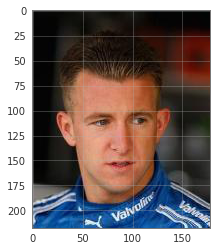

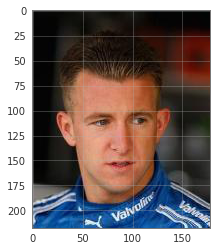

In [110]:
path = "/scratch/datasets/CelebA/Img_Full/train/0/142586.jpg"
orig_img = mpimg.imread(path)
imgplot = plt.imshow(orig_img)
plt.show()

path = '//scratch/datasets/CelebA/img_align_celeba/{0:06d}.jpg'.format(142586)
orig_img = mpimg.imread(path)
imgplot = plt.imshow(orig_img)
plt.show()

/home/vk352/FaceDetection/datasets/celeba/img_align_celeba/000002.jpg


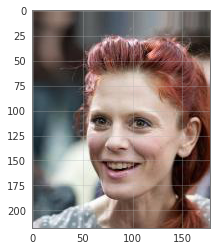

[[ 69. 110.]
 [107. 112.]
 [ 81. 135.]
 [ 70. 151.]
 [108. 153.]]


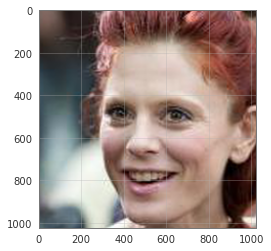

/home/vk352/FaceDetection/datasets/celeba/img_align_celeba/000011.jpg


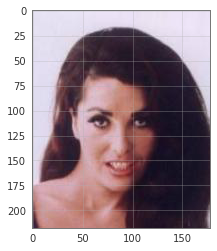

[[ 69. 112.]
 [108. 111.]
 [ 89. 139.]
 [ 72. 152.]
 [104. 151.]]


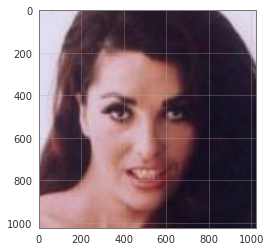

/home/vk352/FaceDetection/datasets/celeba/img_align_celeba/000101.jpg


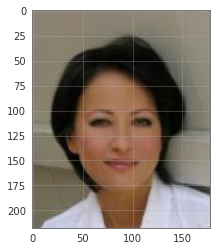

[[ 69. 112.]
 [108. 111.]
 [ 92. 136.]
 [ 71. 152.]
 [105. 151.]]


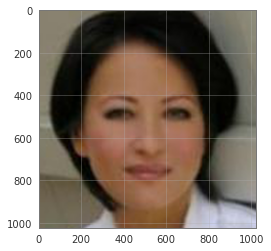

/home/vk352/FaceDetection/datasets/celeba/img_align_celeba/001001.jpg


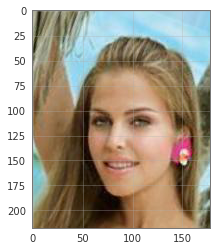

[[ 69. 111.]
 [108. 112.]
 [ 77. 132.]
 [ 70. 151.]
 [108. 153.]]


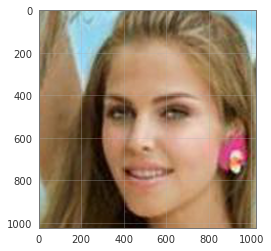

/home/vk352/FaceDetection/datasets/celeba/img_align_celeba/010001.jpg


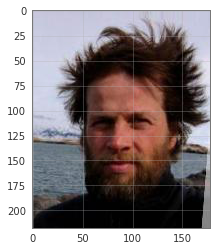

[[ 70. 112.]
 [108. 110.]
 [ 82. 135.]
 [ 74. 153.]
 [101. 152.]]


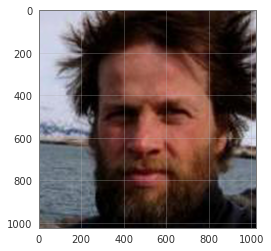

/home/vk352/FaceDetection/datasets/celeba/img_align_celeba/000010.jpg


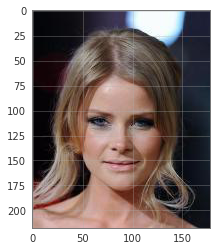

[[ 68. 111.]
 [108. 112.]
 [ 89. 136.]
 [ 70. 151.]
 [107. 151.]]


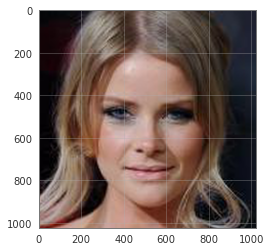

/home/vk352/FaceDetection/datasets/celeba/img_align_celeba/000100.jpg


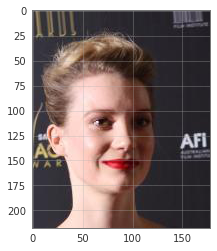

[[ 69. 111.]
 [108. 111.]
 [ 95. 134.]
 [ 69. 151.]
 [107. 152.]]


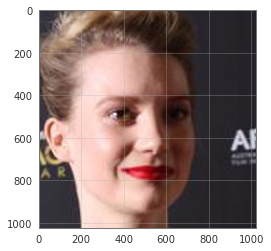

/home/vk352/FaceDetection/datasets/celeba/img_align_celeba/001000.jpg


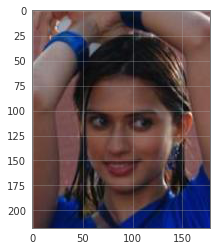

[[ 67. 111.]
 [109. 113.]
 [ 82. 139.]
 [ 70. 152.]
 [108. 150.]]


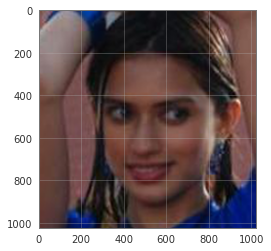

/home/vk352/FaceDetection/datasets/celeba/img_align_celeba/010000.jpg


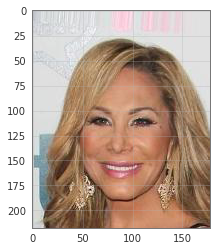

[[ 70. 111.]
 [107. 111.]
 [ 85. 137.]
 [ 67. 152.]
 [111. 153.]]


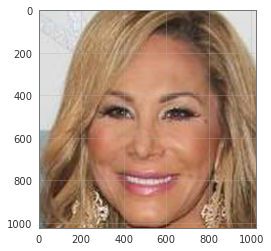

/home/vk352/FaceDetection/datasets/celeba/img_align_celeba/020211.jpg


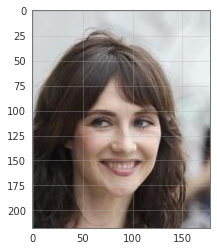

[[ 68. 112.]
 [109. 112.]
 [ 95. 138.]
 [ 67. 150.]
 [110. 151.]]


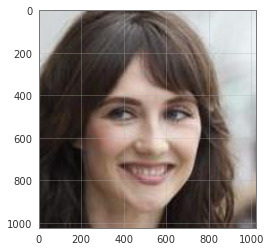

In [109]:
idx_list = [1, 10, 100, 1000, 10000, 9, 99, 999, 9999, 20210]

for idx in idx_list:
    #path = "/scratch/datasets/CelebA/Img/train/0/145590.jpg"
    #path = "/scratch/datasets/CelebA/Img_Full/train/0/142586.jpg"
    path = '/home/vk352/FaceDetection/datasets/celeba/img_align_celeba/{0:06d}.jpg'.format(idx+1)
    print(path)
    img = process_func_2(path, idx)
    rgb_img = Image.fromarray(np.transpose(img, (1, 2, 0)), 'RGB')
    plt.imshow(rgb_img)
    plt.show()
    rgb_img.save("aligned_images_for_test/{0:06d}.jpg".format(idx+1))

In [10]:
num_threads = 1
p = ThreadPool(num_threads)

train_data_path = '/scratch/datasets/CelebA/Img_Full/train/'
test_data_path = '/scratch/datasets/CelebA/Img_Full/test/'
train_aligned_data_path = '/scratch/rw565/CelebA/Img_cropped/train/'
test_aligned_data_path = '/scratch/rw565/CelebA/Img_cropped/test/'

for (data_path, data_save_path) in [(train_data_path, train_aligned_data_path), (test_data_path, test_aligned_data_path)]:
    os.makedirs(data_save_path, exist_ok=True)
    print(data_path)
    id_set = set([f for f in os.listdir(data_path) if not f.endswith("txt")])
    id_list = list(id_set)

    def img_process(person_id):
        data_person_path = os.path.join(data_path, person_id)
        data_person_save_path = os.path.join(data_save_path, person_id)
        os.makedirs(data_person_save_path, exist_ok=True)
        fig_id_list = [f for f in os.listdir(data_person_path) if f.endswith("jpg")]
        for fig_id in fig_id_list:
            orig_img_path = os.path.join(data_person_path, fig_id)
            save_img_path = os.path.join(data_person_save_path, fig_id)
            idx = int(fig_id.split(".")[0]) - 1
            output_img = process_func_2(orig_img_path, idx)
            output_img = Image.fromarray(np.transpose(output_img, (1, 2, 0)), 'RGB')
            output_img.save(save_img_path)

    _ = list(tqdm(p.imap(img_process, id_list), total=len(id_list), desc='thread_img_process'))


thread_img_process:   0%|          | 0/10177 [00:00<?, ?it/s]

/scratch/datasets/CelebA/Img_Full/train/


thread_img_process:   0%|          | 2/10177 [03:51<327:32:24, 115.89s/it]


KeyboardInterrupt: 